<a href="https://colab.research.google.com/github/JoaoCuri2024/book_recommendation/blob/main/Detec%C3%A7%C3%A3o_de_Intrus%C3%A3o_em_Redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------------------------
# Detecção de Intrusão em Redes

--------------------------------------------------



**1. Análise Inicial dos Dados**

1.1 Importação de Bibliotecas

In [ ]:
!pip install optuna
!pip install xgboost
!pip install umap-learn


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.semi_supervised import SelfTrainingClassifier
from imblearn.over_sampling import SMOTE
import optuna

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from imblearn.under_sampling import TomekLinks


from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import NearMiss
import time



from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.impute import SimpleImputer, KNNImputer



import warnings

warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


1.2 Carregamento e Análise Inicial dos Dados

In [ ]:
# Carregando o dataset
base = pd.read_excel('base_ataque.xlsx')

In [ ]:
df = base.copy()

In [ ]:
# Resumo inicial do dataset
print("Informações do dataset:")
print(df.info())

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94719 entries, 0 to 94718
Data columns (total 84 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id.orig_p                 94719 non-null  int64  
 1   id.resp_p                 94719 non-null  int64  
 2   proto                     94719 non-null  object 
 3   service                   94719 non-null  object 
 4   flow_duration             94719 non-null  float64
 5   fwd_pkts_tot              94719 non-null  int64  
 6   bwd_pkts_tot              94719 non-null  int64  
 7   fwd_data_pkts_tot         94719 non-null  int64  
 8   bwd_data_pkts_tot         94719 non-null  int64  
 9   fwd_pkts_per_sec          94719 non-null  float64
 10  bwd_pkts_per_sec          94719 non-null  float64
 11  flow_pkts_per_sec         94719 non-null  float64
 12  down_up_ratio             94719 non-null  float64
 13  fwd_header_size_tot       94719 non-n

In [ ]:
df = base.copy()

In [ ]:
print("\nResumo estatístico:")
print(df.describe())


Resumo estatístico:
          id.orig_p     id.resp_p  flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
count  94719.000000  94719.000000   94719.000000  94719.000000  94719.000000   
mean   35821.499720   1312.111002       4.951723      2.649236      2.213072   
std    18805.666288   5960.595636     148.199417     25.453482     37.638331   
min        0.000000      0.000000       0.000000      0.000000      0.000000   
25%    19747.500000     21.000000       0.000001      1.000000      1.000000   
50%    38706.000000     21.000000       0.000004      1.000000      1.000000   
75%    51200.000000     53.000000       0.000005      1.000000      1.000000   
max    65534.000000  65389.000000   21728.335578   4345.000000  10112.000000   

       fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  \
count       94719.000000       94719.000000      9.471900e+04   
mean            1.612496           1.066185      3.233888e+05   
std            22.384053          36.814604      3.664393e+05  

In [ ]:
# Analisar valores ausentes
missing_values = df.isnull().sum()
print("\nValores ausentes por coluna:")
print(missing_values[missing_values > 0])


Valores ausentes por coluna:
Attack_type    66304
dtype: int64


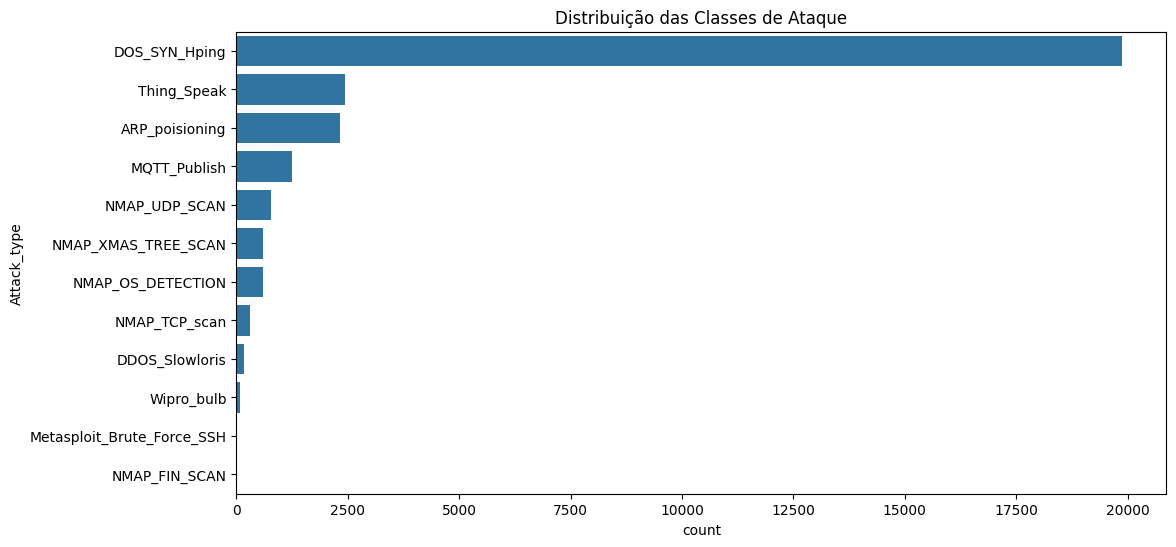

In [ ]:
# Visualizar a distribuição da variável target (Attack_type)
plt.figure(figsize=(12, 6))
sns.countplot(y='Attack_type', data=df, order=df['Attack_type'].value_counts().index)
plt.title('Distribuição das Classes de Ataque')
plt.show()

**2. Separar Dados Rotulados e Não Rotulados**

In [ ]:
# Separar os dados com e sem rótulos
labeled_data = df[df['Attack_type'].notnull()]
unlabeled_data = df[df['Attack_type'].isnull()]

In [ ]:
# Dividir features e rótulos do conjunto rotulado
X_labeled = labeled_data.drop(columns=['Attack_type'])
y_labeled = labeled_data['Attack_type']

In [ ]:
# Apenas features do conjunto não rotulado
X_unlabeled = unlabeled_data.drop(columns=['Attack_type'])

**3. Pré-processamento dos Dados**


In [ ]:
# Identificar variáveis categóricas e numéricas
numeric_features = X_labeled.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_labeled.select_dtypes(include=['object']).columns

In [ ]:
# Aplicar One-Hot Encoding para variáveis categóricas
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_labeled_encoded = pd.DataFrame(ohe.fit_transform(X_labeled[categorical_features]))
X_unlabeled_encoded = pd.DataFrame(ohe.transform(X_unlabeled[categorical_features]))

In [ ]:
# Escalar variáveis numéricas
scaler = RobustScaler()
X_labeled_scaled = pd.DataFrame(scaler.fit_transform(X_labeled[numeric_features]), columns=numeric_features)
X_unlabeled_scaled = pd.DataFrame(scaler.transform(X_unlabeled[numeric_features]), columns=numeric_features)

In [ ]:
# Reunir as variáveis categóricas e numéricas processadas
X_labeled_preprocessed = pd.concat([X_labeled_scaled, X_labeled_encoded.reset_index(drop=True)], axis=1)
X_unlabeled_preprocessed = pd.concat([X_unlabeled_scaled, X_unlabeled_encoded.reset_index(drop=True)], axis=1)

In [ ]:
print("Dimensão dos dados processados (rotulados):", X_labeled_preprocessed.shape)
print("Dimensão dos dados processados (não rotulados):", X_unlabeled_preprocessed.shape)

Dimensão dos dados processados (rotulados): (28415, 94)
Dimensão dos dados processados (não rotulados): (66304, 94)


**3. Self-Training Classifier**

Como temos 70% da nossa variável target faltando vamos Self-Training para aprender com os 30% dos dados rotulados para treinar um modelo inicial que prediz rótulos para os 70% faltantes.

In [ ]:
# Criar o modelo base supervisionado
base_model = RandomForestClassifier(random_state=42)

In [ ]:
# Criar o modelo Self-Training
self_training_model = SelfTrainingClassifier(base_model, criterion='k_best', k_best=10)

In [ ]:
# Converter os nomes das colunas para strings
X_labeled_preprocessed.columns = X_labeled_preprocessed.columns.astype(str)

# Garantir que o target está no formato correto
y_labeled = np.array(y_labeled)

# Treinar o modelo
self_training_model.fit(X_labeled_preprocessed, y_labeled)


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:284: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:289: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(


SelfTrainingClassifier(criterion='k_best',
                       estimator=RandomForestClassifier(random_state=42))

In [ ]:
# Converter os nomes das colunas para strings
X_unlabeled_preprocessed.columns = X_unlabeled_preprocessed.columns.astype(str)

# Prever os valores para os dados não rotulados
y_unlabeled_pred = self_training_model.predict(X_unlabeled_preprocessed)

# Adicionar os valores previstos ao conjunto de dados
unlabeled_data['Attack_type'] = y_unlabeled_pred


<ipython-input-22-8465aab2b50a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_data['Attack_type'] = y_unlabeled_pred


3.1. Combinar Dados Rotulados e Imputados

In [ ]:
# Combinar os dados rotulados e imputados
df_filled = pd.concat([labeled_data, unlabeled_data], axis=0)

# Verificar se todos os valores ausentes foram preenchidos
print("\nValores ausentes restantes em 'Attack_type':", df_filled['Attack_type'].isnull().sum())


Valores ausentes restantes em 'Attack_type': 0


3.2. Criar nova classificação

In [ ]:
# Listas de classificação
ataques = ['DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN',
           'NMAP_OS_DETECTION', 'NMAP_TCP_scan', 'DDOS_Slowloris', 'Wipro_bulb',
           'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN']

normais = ['Thing_Speak', 'MQTT_Publish', 'Wipro_bulb']

# Função para classificar
def classify_attack(attack_type):
    if pd.isna(attack_type):  # Caso esteja vazio
        return np.nan
    elif attack_type in ataques:  # Se for ataque
        return 'ataque'
    elif attack_type in normais:  # Se for normal
        return 'normal'
    else:  # Caso não se encaixe em nenhuma das listas
        return 'desconhecido'

# Criando a nova coluna 'classificacao'
df_filled['classificacao'] = df_filled['Attack_type'].apply(classify_attack)

In [ ]:
# Dividir features e rótulos
X = df_filled.drop(columns=['classificacao'])
y = df_filled['classificacao']

In [ ]:
# Verificar os valores únicos na coluna de classificação
print("Valores únicos na coluna 'classificacao':", df_filled['classificacao'].unique())

Valores únicos na coluna 'classificacao': ['ataque' 'normal']


In [ ]:
total_nulos = df_filled['classificacao'].isnull().sum()
total_registros = len(df_filled)
proporcao_nulos = total_nulos / total_registros
print(f"Proporção de nulos: {proporcao_nulos:.2%}")

Proporção de nulos: 0.00%


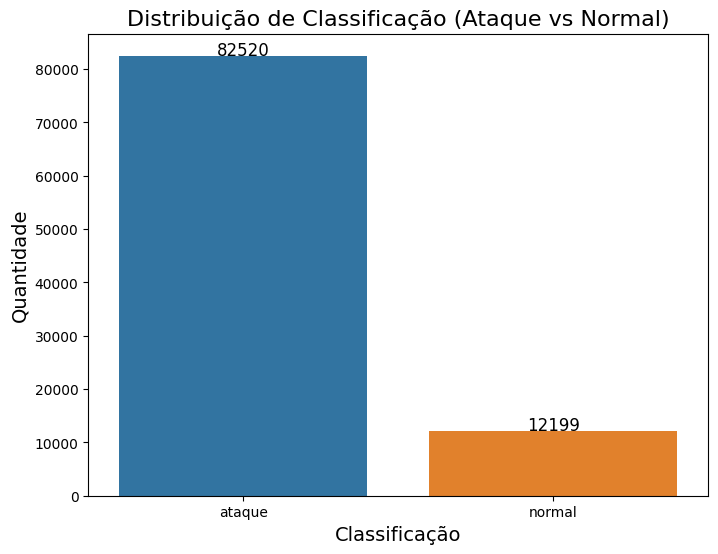

In [ ]:
# Contar as ocorrências de cada categoria (ataque ou normal)
counts = df_filled['classificacao'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values, hue=counts.index, dodge=False, legend=False)  # Removendo 'palette'

# Adicionar título e rótulos
plt.title('Distribuição de Classificação (Ataque vs Normal)', fontsize=16)
plt.xlabel('Classificação', fontsize=14)
plt.ylabel('Quantidade', fontsize=14)

# Adicionar os valores acima das barras
for i, value in enumerate(counts.values):
    plt.text(i, value + 50, str(value), ha='center', fontsize=12)

# Mostrar o gráfico
plt.show()

**5. Balanceamento com SMOTE**

Como os dados estão bastante desiquilibrados, isso pode prejudicar o modelo, pois pode falhar em identificar as Classes com menor incidência. O algoritmo irá se ajusta demasiadamente aos resultados, classificando boa parte como não ataque. Isso ocorre, uma vez que o modelo aprenderá de maneira excessiva os padrões da classe majoritária.(Overfiting).

Para evitar que isso ocorra aplicamos o SMOTE (Synthetic Minority Oversampling Technique) é uma técnica usada para lidar com desbalanceamento de classes em conjuntos de dados. Ele funciona criando exemplos sintéticos para a classe minoritária, em vez de simplesmente replicar os existentes. Isso é feito interpolando dados entre instâncias reais da classe minoritária, ajudando a melhorar o desempenho de modelos em problemas com classes desbalanceadas.

In [ ]:
# Dividir features e rótulos
X = df_filled.drop(columns=['classificacao'])
y = df_filled['classificacao']

In [ ]:
# Transformar colunas categóricas usando One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_encoded, y)

# Verificar os dados balanceados
print("Dados balanceados:")
print("X_balanced shape:", X_balanced.shape)
print("y_balanced shape:", y_balanced.shape)

Dados balanceados:
X_balanced shape: (165040, 103)
y_balanced shape: (165040,)


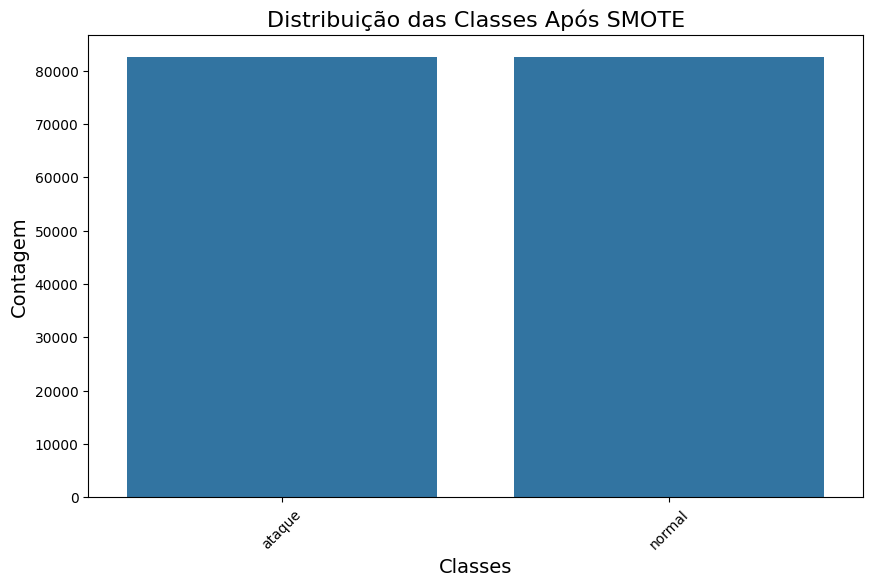

In [ ]:
# Plotar gráfico de barras para y_balanced
plt.figure(figsize=(10, 6))
sns.countplot(x=y_balanced)
plt.title("Distribuição das Classes Após SMOTE", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Contagem", fontsize=14)
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x, se necessário
plt.show()

**6. Seleção das 20 Variáveis Mais Importantes**

São 83 variáveis, trabalhar com tudo isso seria honeroso em uso computacional e não muito eficiênte. Por isso vamos selecionar as 15 variáveis mais importantes para poder utilizar no modelo.

In [ ]:
# Treinar Random Forest para calcular a importância das features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_balanced, y_balanced)

RandomForestClassifier(random_state=42)

In [ ]:
# Obter a importância das variáveis
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)


In [ ]:
# Selecionar as 20 variáveis mais importantes
top_features = feature_importance.head(20)['Feature'].values
print("\nAs 20 variáveis mais importantes são:\n", top_features)


As 20 variáveis mais importantes são:
 ['fwd_iat.min' 'flow_iat.min' 'flow_iat.avg' 'active.tot' 'fwd_iat.tot'
 'active.avg' 'fwd_iat.avg' 'active.max' 'active.min' 'flow_duration'
 'flow_iat.max' 'flow_iat.tot' 'fwd_iat.max' 'bwd_subflow_bytes'
 'fwd_data_pkts_tot' 'bwd_iat.tot' 'bwd_iat.max' 'bwd_data_pkts_tot'
 'bwd_pkts_payload.avg' 'flow_iat.std']


In [ ]:
# Reduzir o dataset para as 10 variáveis mais importantes
X_reduced = X_balanced[top_features]

**7. Divisão Treino-Teste e Treinamento Final do Modelo**

In [ ]:
# Criando uma função que faz o Stacking já que a do sklearn não está funcionando
class CustomStackingClassifier:
    def __init__(self, base_models, meta_model, n_folds=5, random_state=42):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.random_state = random_state
        self.label_encoder = LabelEncoder()

    def fit(self, X, y):
        # Initialize cloned models
        self.base_models_ = [clone(model) for name, model in self.base_models]
        self.meta_model_ = clone(self.meta_model)

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)

        # Initialize meta-features array
        meta_features = np.zeros((X.shape[0], len(self.base_models)))

        # Create cross-validation splits
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        # Generate meta-features
        for i, model in enumerate(self.base_models_):
            # Train and predict for each fold
            for train_idx, val_idx in kf.split(X):
                X_train_fold = X[train_idx]
                y_train_fold = y_encoded[train_idx]
                X_val_fold = X[val_idx]

                # Fit the model on training fold
                model.fit(X_train_fold, y_train_fold)

                # Generate predictions for validation fold
                meta_features[val_idx, i] = model.predict(X_val_fold)

        # Train base models on full dataset
        for i, model in enumerate(self.base_models_):
            model.fit(X, y_encoded)

        # Train meta-model
        self.meta_model_.fit(meta_features, y_encoded)

        return self

    def predict(self, X):
        # Generate predictions from base models
        meta_features = np.column_stack([
            model.predict(X) for model in self.base_models_
        ])

        # Get predictions from meta-model
        y_pred_encoded = self.meta_model_.predict(meta_features)

        # Decode predictions back to original labels
        return self.label_encoder.inverse_transform(y_pred_encoded)

    def predict_proba(self, X):
        # Generate predictions from base models
        meta_features = np.column_stack([
            model.predict(X) for model in self.base_models_
        ])

        # Get probability predictions from meta-model if it supports predict_proba
        if hasattr(self.meta_model_, 'predict_proba'):
            return self.meta_model_.predict_proba(meta_features)
        else:
            raise AttributeError("Meta-model doesn't support predict_proba")

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_balanced, test_size=0.2, random_state=42)

# Reset indices
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Define base models
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Define meta-model
final_model = LogisticRegression()

# Create and train stacking classifier
stacking = CustomStackingClassifier(
    base_models=base_models,
    meta_model=final_model,
    n_folds=5,
    random_state=42
)

# Fit the model
stacking.fit(X_train.values, y_train.values)

# Make predictions
y_pred = stacking.predict(X_test.values)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 52685, number of negative: 52940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5059
[LightGBM] [Info] Number of data points in the train set: 105625, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498793 -> initscore=-0.004828
[LightGBM] [Info] Start training from score -0.004828
[LightGBM] [Info] Number of positive: 52646, number of negative: 52979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5058
[LightGBM] [Info] Number of data points in the train set: 105625, number of used features: 20
[LightGBM] [Info

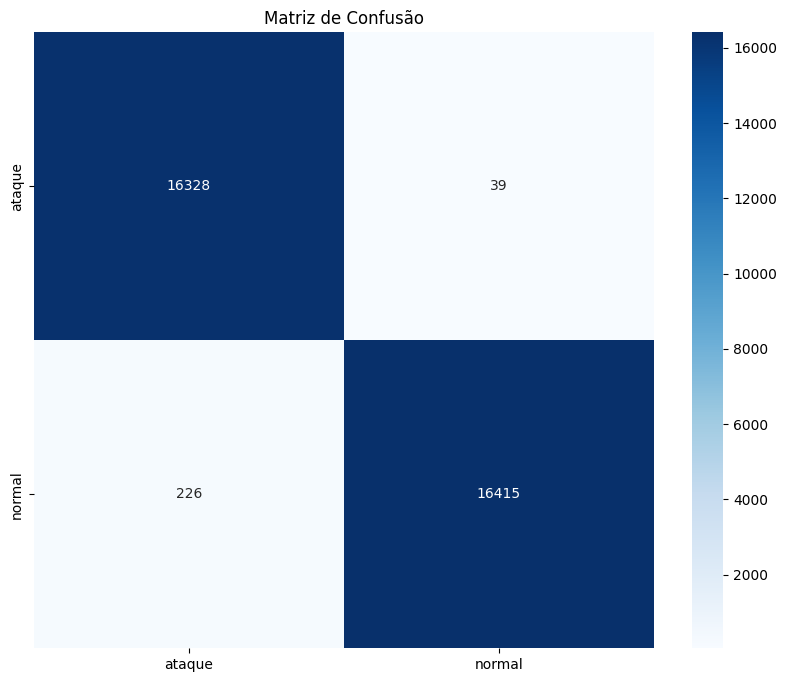

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_balanced), yticklabels=np.unique(y_balanced))
plt.title("Matriz de Confusão")
plt.show()

Um teste ajustando os hiperparametros


In [ ]:
class CustomStackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        base_models,
        meta_model,
        n_folds=5,
        random_state=42,
        use_proba=True,
        stratified=True,
        feature_subset=0.8,
        max_train_time=3600  # 1 hora máximo
    ):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.random_state = random_state
        self.label_encoder = LabelEncoder()
        self.use_proba = use_proba
        self.stratified = stratified
        self.feature_subset = feature_subset
        self.max_train_time = max_train_time
        self.start_time = None

    def _check_time(self):
        """Verifica se excedeu o tempo máximo de treinamento"""
        if time.time() - self.start_time > self.max_train_time:
            raise TimeoutError("Treinamento excedeu o tempo máximo permitido")

    def _get_feature_subset(self, X):
        """Seleciona um subconjunto aleatório de features"""
        n_features = int(X.shape[1] * self.feature_subset)
        return np.random.choice(X.shape[1], n_features, replace=False)

    def fit(self, X, y):
        self.start_time = time.time()

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_

        # Initialize meta-features array
        n_classes = len(self.classes_)
        if self.use_proba:
            meta_features = np.zeros((X.shape[0], len(self.base_models) * n_classes))
        else:
            meta_features = np.zeros((X.shape[0], len(self.base_models)))

        # Choose cross-validation strategy
        if self.stratified:
            kf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        else:
            kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        # Train and generate meta-features
        self.base_models_ = []

        # Pre-calculate folds para evitar recálculos
        folds = list(kf.split(X, y_encoded))

        for i, (name, model) in enumerate(self.base_models):
            self._check_time()

            # Clone and initialize model
            base_model = clone(model)

            # Select feature subset for this model
            feature_idx = self._get_feature_subset(X)
            X_subset = X[:, feature_idx]

            # Generate meta-features through cross-validation
            for train_idx, val_idx in folds:
                self._check_time()

                X_train_fold = X_subset[train_idx]
                y_train_fold = y_encoded[train_idx]
                X_val_fold = X_subset[val_idx]

                # Fit model
                base_model.fit(X_train_fold, y_train_fold)

                # Generate predictions
                if self.use_proba:
                    fold_pred = base_model.predict_proba(X_val_fold)
                    meta_features[val_idx, i*n_classes:(i+1)*n_classes] = fold_pred
                else:
                    meta_features[val_idx, i] = base_model.predict(X_val_fold)

            # Fit final model on all data
            base_model.fit(X_subset, y_encoded)
            self.base_models_.append((feature_idx, base_model))

        # Train meta-model
        self._check_time()
        self.meta_model_ = clone(self.meta_model)
        self.meta_model_.fit(meta_features, y_encoded)

        return self

    def predict(self, X):
        meta_features = self._get_meta_features(X)
        y_pred_encoded = self.meta_model_.predict(meta_features)
        return self.label_encoder.inverse_transform(y_pred_encoded)

    def predict_proba(self, X):
        meta_features = self._get_meta_features(X)
        return self.meta_model_.predict_proba(meta_features)

    def _get_meta_features(self, X):
        n_classes = len(self.classes_)
        if self.use_proba:
            meta_features = np.zeros((X.shape[0], len(self.base_models) * n_classes))

            for i, (feature_idx, model) in enumerate(self.base_models_):
                X_subset = X[:, feature_idx]
                pred = model.predict_proba(X_subset)
                meta_features[:, i*n_classes:(i+1)*n_classes] = pred
        else:
            meta_features = np.zeros((X.shape[0], len(self.base_models)))

            for i, (feature_idx, model) in enumerate(self.base_models_):
                X_subset = X[:, feature_idx]
                meta_features[:, i] = model.predict(X_subset)

        return meta_features

    def score(self, X, y):
        """Calcula a acurácia do modelo"""
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [ ]:

class CustomStackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        base_models,
        meta_model,
        n_folds=5,
        random_state=42,
        use_proba=True,
        stratified=True,
        feature_subset=0.8,
        max_train_time=3600  # 1 hora máximo
    ):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.random_state = random_state
        self.label_encoder = LabelEncoder()
        self.use_proba = use_proba
        self.stratified = stratified
        self.feature_subset = feature_subset
        self.max_train_time = max_train_time
        self.start_time = None

    def _check_time(self):
        """Verifica se excedeu o tempo máximo de treinamento"""
        if time.time() - self.start_time > self.max_train_time:
            raise TimeoutError("Treinamento excedeu o tempo máximo permitido")

    def _get_feature_subset(self, X):
        """Seleciona um subconjunto aleatório de features"""
        n_features = int(X.shape[1] * self.feature_subset)
        return np.random.choice(X.shape[1], n_features, replace=False)

    def fit(self, X, y):
        self.start_time = time.time()

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_

        # Initialize meta-features array
        n_classes = len(self.classes_)
        if self.use_proba:
            meta_features = np.zeros((X.shape[0], len(self.base_models) * n_classes))
        else:
            meta_features = np.zeros((X.shape[0], len(self.base_models)))

        # Choose cross-validation strategy
        if self.stratified:
            kf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        else:
            kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        # Train and generate meta-features
        self.base_models_ = []

        # Pre-calculate folds para evitar recálculos
        folds = list(kf.split(X, y_encoded))

        for i, (name, model) in enumerate(self.base_models):
            self._check_time()

            # Clone and initialize model
            base_model = clone(model)

            # Select feature subset for this model
            feature_idx = self._get_feature_subset(X)
            X_subset = X[:, feature_idx]

            # Generate meta-features through cross-validation
            for train_idx, val_idx in folds:
                self._check_time()

                X_train_fold = X_subset[train_idx]
                y_train_fold = y_encoded[train_idx]
                X_val_fold = X_subset[val_idx]

                # Fit model
                base_model.fit(X_train_fold, y_train_fold)

                # Generate predictions
                if self.use_proba:
                    fold_pred = base_model.predict_proba(X_val_fold)
                    meta_features[val_idx, i*n_classes:(i+1)*n_classes] = fold_pred
                else:
                    meta_features[val_idx, i] = base_model.predict(X_val_fold)

            # Fit final model on all data
            base_model.fit(X_subset, y_encoded)
            self.base_models_.append((feature_idx, base_model))

        # Train meta-model
        self._check_time()
        self.meta_model_ = clone(self.meta_model)
        self.meta_model_.fit(meta_features, y_encoded)

        return self

    def predict(self, X):
        meta_features = self._get_meta_features(X)
        y_pred_encoded = self.meta_model_.predict(meta_features)
        return self.label_encoder.inverse_transform(y_pred_encoded)

    def predict_proba(self, X):
        meta_features = self._get_meta_features(X)
        return self.meta_model_.predict_proba(meta_features)

    def _get_meta_features(self, X):
        n_classes = len(self.classes_)
        if self.use_proba:
            meta_features = np.zeros((X.shape[0], len(self.base_models) * n_classes))

            for i, (feature_idx, model) in enumerate(self.base_models_):
                X_subset = X[:, feature_idx]
                pred = model.predict_proba(X_subset)
                meta_features[:, i*n_classes:(i+1)*n_classes] = pred
        else:
            meta_features = np.zeros((X.shape[0], len(self.base_models)))

            for i, (feature_idx, model) in enumerate(self.base_models_):
                X_subset = X[:, feature_idx]
                meta_features[:, i] = model.predict(X_subset)

        return meta_features

    def score(self, X, y):
        """Calcula a acurácia do modelo"""
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [ ]:
# Configurações mais leves para os modelos base
base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=50,  # Reduzido
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42
    )),
    ('xgb', XGBClassifier(
        n_estimators=50,  # Reduzido
        max_depth=4,
        learning_rate=0.1,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    )),
    ('lgbm', LGBMClassifier(
        n_estimators=50,  # Reduzido
        max_depth=4,
        learning_rate=0.1,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    ))
]

# Meta-modelo
final_model = LogisticRegression(C=0.1, max_iter=500)  # Reduzido max_iter

# Criar o stacking classifier com timeout
stacking = CustomStackingClassifier(
    base_models=base_models,
    meta_model=final_model,
    n_folds=3,  # Reduzido número de folds
    random_state=42,
    use_proba=True,
    stratified=True,
    feature_subset=0.7,
    max_train_time=1800  # 30 minutos máximo
)

# Treinar e avaliar usando validação cruzada
cv_scores = cross_val_score(stacking, X_reduced.values, y_balanced, cv=3)  # Reduzido número de folds
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

[LightGBM] [Info] Number of positive: 50226, number of negative: 23124
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3537
[LightGBM] [Info] Number of data points in the train set: 73350, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.684744 -> initscore=0.775662
[LightGBM] [Info] Start training from score 0.775662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

**8. Balanceamento com NearMiss**

É uma técnica de subamostragem eficaz que seleciona as instâncias da classe majoritária que são mais próximas das instâncias na classe minoritária. Essa técnica visa manter as instâncias que são mais informativas e representativas da classe majoritária, enquanto remove as instâncias redundantes e ruidosas.

In [ ]:
# Dividir features e rótulos
X = df_filled.drop(columns=['classificacao'])
y = df_filled['classificacao']


In [ ]:
# Transformar colunas categóricas usando One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Aplicar NearMiss para undersampling
nearmiss = NearMiss(version=1)  # Você pode testar outras versões, como version=2 ou version=3
X_balanced, y_balanced = nearmiss.fit_resample(X_encoded, y)

# Verificar os dados balanceados
print("Dados balanceados com NearMiss:")
print("X_balanced shape:", X_balanced.shape)
print("y_balanced shape:", y_balanced.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The NearMiss or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Dados balanceados com NearMiss:
X_balanced shape: (24398, 103)
y_balanced shape: (24398,)


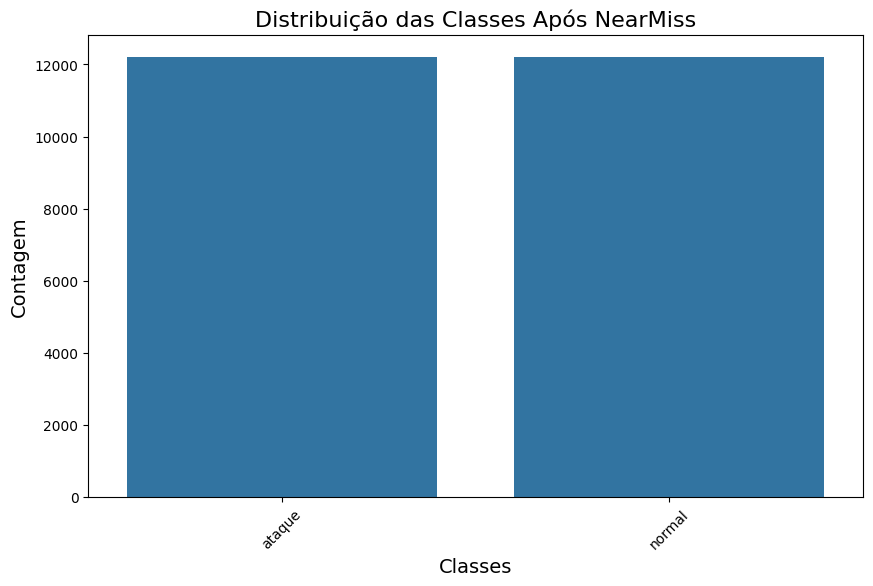

In [ ]:
# Plotar gráfico de barras para y_balanced
plt.figure(figsize=(10, 6))
sns.countplot(x=y_balanced)
plt.title("Distribuição das Classes Após NearMiss", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Contagem", fontsize=14)
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x, se necessário
plt.show()

In [ ]:
# Treinar Random Forest para calcular a importância das features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_balanced, y_balanced)

# Obter a importância das variáveis
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [ ]:
# Selecionar as 20 variáveis mais importantes
top_features = feature_importance.head(20)['Feature'].values
print("\nAs 20 variáveis mais importantes são:\n", top_features)


As 20 variáveis mais importantes são:
 ['fwd_iat.tot' 'fwd_iat.avg' 'flow_iat.min' 'active.tot' 'flow_iat.tot'
 'fwd_iat.max' 'fwd_iat.min' 'flow_duration' 'flow_iat.avg' 'active.max'
 'flow_pkts_per_sec' 'Attack_type_Thing_Speak' 'flow_iat.max'
 'bwd_data_pkts_tot' 'active.min' 'bwd_pkts_per_sec' 'bwd_iat.tot'
 'fwd_pkts_payload.avg' 'bwd_subflow_bytes' 'fwd_pkts_per_sec']


In [ ]:
# Reduzir o dataset para as 20 variáveis mais importantes
X_reduced = X_balanced[top_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_balanced, test_size=0.2, random_state=42)

# Reset indices
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

In [ ]:
# Define base models
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Define meta-model
final_model = LogisticRegression()

# Create and train stacking classifier
stacking = CustomStackingClassifier(
    base_models=base_models,
    meta_model=final_model,
    n_folds=5,
    random_state=42
)

# Codificar rótulos usando LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Fit the model
stacking.fit(X_train.values, y_train_encoded)

# Make predictions
y_pred_encoded = stacking.predict(X_test.values)

# Decodificar os rótulos de volta para strings originais
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:01:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:01:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:01:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed

[LightGBM] [Info] Number of positive: 7834, number of negative: 7780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3673
[LightGBM] [Info] Number of data points in the train set: 15614, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501729 -> initscore=0.006917
[LightGBM] [Info] Start training from score 0.006917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7833, number of negative: 7781
[L

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 7833, number of negative: 7781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3675
[LightGBM] [Info] Number of data points in the train set: 15614, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501665 -> initscore=0.006661
[LightGBM] [Info] Start training from score 0.006661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7834, number of negative: 7781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3676
[LightGBM] [Info] Nu

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 7834, number of negative: 7781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3678
[LightGBM] [Info] Number of data points in the train set: 15615, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501697 -> initscore=0.006788
[LightGBM] [Info] Start training from score 0.006788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 9792, number of negative: 9726
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_col_wise=true` to 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**9. TomekLinks**

É uma técnica de undersampling que remove pares de instâncias próximas, onde uma pertence à classe majoritária e a outra à classe minoritária. Isso ajuda a criar uma fronteira mais clara entre as classes.

In [ ]:
# Dividir features e rótulos
X = df_filled.drop(columns=['classificacao'])
y = df_filled['classificacao']

# Transformar colunas categóricas usando One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

In [ ]:
# Aplicar Tomek Links para undersampling
tomek = TomekLinks()
X_balanced, y_balanced = tomek.fit_resample(X_encoded, y)

# Verificar os dados balanceados
print("Dados balanceados com Tomek Links:")
print("X_balanced shape:", X_balanced.shape)
print("y_balanced shape:", y_balanced.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Dados balanceados com Tomek Links:
X_balanced shape: (94587, 103)
y_balanced shape: (94587,)


In [ ]:
# Treinar Random Forest para calcular a importância das features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_balanced, y_balanced)

# Obter a importância das variáveis
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Selecionar as 20 variáveis mais importantes
top_features = feature_importance.head(20)['Feature'].values
print("\nAs 20 variáveis mais importantes são:\n", top_features)

# Reduzir o dataset para as 15 variáveis mais importantes
X_reduced = X_balanced[top_features]


As 20 variáveis mais importantes são:
 ['Attack_type_Thing_Speak' 'flow_iat.min' 'flow_iat.avg' 'active.tot'
 'flow_duration' 'active.max' 'active.min' 'bwd_subflow_bytes' 'id.resp_p'
 'flow_iat.max' 'flow_iat.tot' 'Attack_type_DOS_SYN_Hping'
 'bwd_pkts_payload.tot' 'bwd_data_pkts_tot' 'bwd_pkts_per_sec'
 'fwd_iat.tot' 'bwd_pkts_payload.max' 'bwd_pkts_payload.avg' 'active.avg'
 'fwd_pkts_payload.avg']


In [ ]:
# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_balanced, test_size=0.2, random_state=42)

# Reset indices
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Codificar rótulos usando LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Definir modelos base
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Definir o meta-modelo
final_model = LogisticRegression()

# Criar e treinar o stacking classifier
stacking = CustomStackingClassifier(
    base_models=base_models,
    meta_model=final_model,
    n_folds=5,
    random_state=42
)

# Ajustar o modelo
stacking.fit(X_train.values, y_train_encoded)

# Fazer previsões
y_pred_encoded = stacking.predict(X_test.values)

# Decodificar as previsões para os rótulos originais
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Imprimir relatório de classificação
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:14:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:14:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:14:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:14:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 an

[LightGBM] [Info] Number of positive: 52641, number of negative: 52947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3573
[LightGBM] [Info] Number of data points in the train set: 105588, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498551 -> initscore=-0.005796
[LightGBM] [Info] Start training from score -0.005796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 52641, number of negative: 52947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3573
[LightGBM] [Info] Number of data points in the train set: 105588, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498551 -> initscore=-0.005796
[LightGBM] [Info] Start training from score -0.005796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 52642, number of negative: 52946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 105588, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498560 -> initscore=-0.005758
[LightGBM] [Info] Start training from score -0.005758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 52642, number of negative: 52946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 105588, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498560 -> initscore=-0.005758
[LightGBM] [Info] Start training from score -0.005758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 52642, number of negative: 52946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 105588, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498560 -> initscore=-0.005758
[LightGBM] [Info] Start training from score -0.005758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 65802, number of negative: 66183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 131985, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498557 -> initscore=-0.005773
[LightGBM] [Info] Start training from score -0.005773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

      ataque       1.00      1.00      1.00     16337
      normal       1.00      1.00      1.00     16660

    accuracy                           1.00     32997
   macro avg       1.00      1.00      1.00     32997
weighted avg       1.00      1.00      1.00     32997



Há sinais de overfiting

**10. ADASYN**

O ADASYN (Adaptive Synthetic Sampling) é uma técnica de oversampling que gera novos exemplos sintéticos para as classes minoritárias de forma adaptativa, concentrando-se nas regiões de decisão mais difíceis.


In [ ]:
from imblearn.over_sampling import ADASYN

# Dividir features e rótulos
X = df_filled.drop(columns=['classificacao'])
y = df_filled['classificacao']

# Transformar colunas categóricas usando One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Aplicar ADASYN para oversampling adaptativo
adasyn = ADASYN(random_state=42)
X_balanced, y_balanced = adasyn.fit_resample(X_encoded, y)

# Verificar os dados balanceados
print("Dados balanceados com ADASYN:")
print("X_balanced shape:", X_balanced.shape)
print("y_balanced shape:", y_balanced.shape)

# Treinar Random Forest para calcular a importância das features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_balanced, y_balanced)

# Obter a importância das variáveis
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Selecionar as 20 variáveis mais importantes
top_features = feature_importance.head(20)['Feature'].values
print("\nAs 20 variáveis mais importantes são:\n", top_features)

# Reduzir o dataset para as 20 variáveis mais importantes
X_reduced = X_balanced[top_features]

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_balanced, test_size=0.2, random_state=42)

# Reset indices
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Codificar rótulos usando LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Definir modelos base
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Definir o meta-modelo
final_model = LogisticRegression()

# Criar e treinar o stacking classifier
stacking = CustomStackingClassifier(
    base_models=base_models,
    meta_model=final_model,
    n_folds=5,
    random_state=42
)

# Ajustar o modelo
stacking.fit(X_train.values, y_train_encoded)

# Fazer previsões
y_pred_encoded = stacking.predict(X_test.values)

# Decodificar as previsões para os rótulos originais
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Imprimir relatório de classificação
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The ADASYN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Dados balanceados com ADASYN:
X_balanced shape: (164982, 103)
y_balanced shape: (164982,)

As 20 variáveis mais importantes são:
 ['Attack_type_Thing_Speak' 'flow_iat.min' 'flow_iat.avg' 'active.tot'
 'flow_duration' 'active.max' 'active.min' 'bwd_subflow_bytes' 'id.resp_p'
 'flow_iat.max' 'flow_iat.tot' 'Attack_type_DOS_SYN_Hping'
 'bwd_pkts_payload.tot' 'bwd_data_pkts_tot' 'bwd_pkts_per_sec'
 'fwd_iat.tot' 'bwd_pkts_payload.max' 'bwd_pkts_payload.avg' 'active.avg'
 'fwd_pkts_payload.avg']


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:15:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:15:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:15:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:16:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:16:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 52641, number of negative: 52947
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3573
[LightGBM] [Info] Number of data points in the train set: 105588, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498551 -> initscore=-0.005796
[LightGBM] [Info] Start training from score -0.005796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 52641, number of negative: 52947
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3573
[LightGBM] [Info] Number of data points in the train set: 105588, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498551 -> initscore=-0.005796
[LightGBM] [Info] Start training from score -0.005796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 52642, number of negative: 52946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 105588, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498560 -> initscore=-0.005758
[LightGBM] [Info] Start training from score -0.005758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 52642, number of negative: 52946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 105588, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498560 -> initscore=-0.005758
[LightGBM] [Info] Start training from score -0.005758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 52642, number of negative: 52946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 105588, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498560 -> initscore=-0.005758
[LightGBM] [Info] Start training from score -0.005758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 65802, number of negative: 66183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 131985, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498557 -> initscore=-0.005773
[LightGBM] [Info] Start training from score -0.005773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

      ataque       1.00      1.00      1.00     16337
      normal       1.00      1.00      1.00     16660

    accuracy                           1.00     32997
   macro avg       1.00      1.00      1.00     32997
weighted avg       1.00      1.00      1.00     32997



Mesmo assim ainda tem sinal de Overfiting

** 11. Teste final**

Aqui uso técnicas de como PCA, t-SNE e UMAP para tentar chegar a uma boa acurácia.

In [ ]:


class FeatureEngineeringPipeline:
    def __init__(self, n_components_pca=0.95, n_components_tsne=2):
        self.n_components_pca = n_components_pca
        self.n_components_tsne = n_components_tsne
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components_pca)
        self.tsne = TSNE(n_components=n_components_tsne, random_state=42)
        self.umap = UMAP(random_state=42)

        # Adicionar imputadores e codificador
        self.numeric_imputer = KNNImputer(n_neighbors=5)
        self.categorical_imputer = SimpleImputer(strategy='most_frequent')
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def impute_and_encode(self, df):
        """Tratar valores ausentes e codificar categorias"""
        numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
        categorical_features = df.select_dtypes(include=['object']).columns

        # Imputar valores ausentes para features numéricas
        if len(numeric_features) > 0:
            df[numeric_features] = pd.DataFrame(
                self.numeric_imputer.fit_transform(df[numeric_features]),
                columns=numeric_features,
                index=df.index
            )

        # Imputar e codificar features categóricas
        if len(categorical_features) > 0:
            df[categorical_features] = self.categorical_imputer.fit_transform(df[categorical_features])
            encoded_cats = pd.DataFrame(
                self.encoder.fit_transform(df[categorical_features]),
                columns=self.encoder.get_feature_names_out(categorical_features),
                index=df.index
            )
            # Substituir categorias originais pelas codificadas
            df = df.drop(columns=categorical_features)
            df = pd.concat([df, encoded_cats], axis=1)

        return df

    def validate_no_missing_values(self, df):
        """Validar que não há valores ausentes no DataFrame"""
        if df.isnull().sum().sum() > 0:
            print("Colunas com valores ausentes após imputação:")
            print(df.isnull().sum()[df.isnull().sum() > 0])
            raise ValueError("Ainda existem valores ausentes no conjunto de dados.")

    def reduce_dimensionality(self, X):
        """Aplicar técnicas de redução de dimensionalidade"""
        X_scaled = self.scaler.fit_transform(X)

        # PCA
        X_pca = self.pca.fit_transform(X_scaled)

        # t-SNE
        n_components_tsne = min(50, X_pca.shape[1])
        X_tsne = self.tsne.fit_transform(X_pca[:, :n_components_tsne])

        # UMAP
        X_umap = self.umap.fit_transform(X_scaled)

        # Combinar resultados
        reduced_features = pd.DataFrame(
            np.hstack([X_pca, X_tsne, X_umap]),
            columns=[
                *(f'pca_{i + 1}' for i in range(X_pca.shape[1])),
                'tsne_1', 'tsne_2',
                'umap_1', 'umap_2'
            ]
        )
        return reduced_features

    def fit_transform(self, df):
        """Aplicar todo o pipeline de feature engineering"""
        # 1. Imputar e codificar valores ausentes
        df = self.impute_and_encode(df)

        # 2. Validar que não há NaNs
        self.validate_no_missing_values(df)

        # 3. Selecionar features numéricas para redução de dimensionalidade
        numeric_features = df.select_dtypes(include=['float64', 'int64'])

        # 4. Aplicar redução de dimensionalidade
        reduced_features = self.reduce_dimensionality(numeric_features)

        # 5. Combinar as features reduzidas com as originais
        final_features = pd.concat([df, reduced_features], axis=1)

        return final_features


def process_data(df):
    pipeline = FeatureEngineeringPipeline()
    enhanced_features = pipeline.fit_transform(df)

    # Separar features e alvo
    X = enhanced_features.drop(['classificacao'], axis=1, errors='ignore')
    y = df['classificacao']

    return X, y


def train_model_with_new_features(df):
    X, y = process_data(df)

    # Dividir os dados
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Treinar o modelo
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Avaliação
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    return model



# Treinar o modelo
model = train_model_with_new_features(df_filled)


              precision    recall  f1-score   support

      ataque       1.00      1.00      1.00     16504
      normal       1.00      1.00      1.00      2440

    accuracy                           1.00     18944
   macro avg       1.00      1.00      1.00     18944
weighted avg       1.00      1.00      1.00     18944



**Conclusão**

O primeiro modelo, SMOTE+ Stacking,com base no relatório de classificação e matriz de confusão parece ser o melhor pois não embora a acurácia seja alta não há sinais claros de overfitting. Mas como fizemos o input de 70% dos dados podemos ter replicado um comportamento que não é real.
Os demais modelos estão com uma acurácia de 100%.

Recomendo que as demais classes sejam preenchidas e executamos novamente o modelo.